In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit.library import StatePreparation
from qiskit.quantum_info import DensityMatrix, partial_trace, state_fidelity
from qclib.machine_learning.datasets import digits
from qclib.state_preparation.util.baa import _split_combinations
from qclib.util import get_cnot_count

from qdna.compression import SchmidtCompressor
from qdna.quantum_info import correlation

In [2]:
# Dataset load.
seed = 42

# Here you can choose the dataset classes. For example: [3], [0,1], [1,8], [2,4,7], etc.
sample_total, training_input, test_input, class_labels = digits.load(classes=[2],
                                                                     training_size=160,
                                                                     test_size=20,
                                                                     random_seed=seed)
feature_dim = len(training_input[class_labels[0]][0])
n_qubits = int(np.ceil(np.log2(feature_dim)))

# Variables to collect data for the summary.
fidelities = [[],[],[]]
figures = [[],[],[]]

In [3]:
# Prints information on training and test datasets.
for _, train_samples in training_input.items():
    print(train_samples.shape)
for _, test_samples in test_input.items():
    print(test_samples.shape)

(157, 64)
(20, 64)


In [4]:
def plot_digits(vectors, num_data_qubits, text=''):
    import matplotlib.pyplot as plt
    _dpi = 96
    matrix_dim_1 = 2**(int(np.ceil(num_data_qubits/2)))
    matrix_dim_2 = 2**(int(np.floor(num_data_qubits/2)))

    ncols = len(vectors)
    _, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(ncols*10*matrix_dim_1/_dpi, 10*matrix_dim_2/_dpi), dpi=_dpi)
    for ax, vector in zip(axes, vectors):
        ax.set_axis_off()
        image = vector.reshape(matrix_dim_1, matrix_dim_2)
        ax.imshow(image, cmap=plt.cm.gray, interpolation='none')

    plt.show()

***
## Experiment main routine
***

In [5]:
# Creates an example of the circuit.
def complete_circuit(state_vector, compressor, decompressor):

    # Typical state initializer.
    initializer = StatePreparation(state_vector)

    # Creates the quantum circuit.
    circuit = QuantumCircuit(n_qubits)

    # Circuit on Alice's side.
    circuit.append(initializer.definition, range(n_qubits))
    circuit.append(compressor.definition, range(n_qubits))
    circuit.reset(compressor.trash_qubits)

    # Circuit on Bob's side.
    circuit.append(decompressor.definition, range(n_qubits))

    return circuit    

def experiment(test_input, compressor, decompressor, verbose=1):
    # Applies the compression-decompression process to each of the test samples.

    fidelities = []
    figures = []

    # Iterates through all test samples.
    for i, test_sample in enumerate(np.concatenate([test_samples for _, test_samples in test_input.items()])):
        circuit = complete_circuit(test_sample, compressor, decompressor)

        # Compares the recovered state with the original state.
        input_state = DensityMatrix(test_sample, dims=2**n_qubits)
        input_probs = input_state.probabilities()
        output_state = partial_trace(DensityMatrix(circuit), range(n_qubits, circuit.num_qubits))
        output_probs = output_state.probabilities()

        fidelity = state_fidelity(input_state, output_state)

        # Stores and prints the results.
        fidelities.append(fidelity)
        figures.append([input_probs, output_probs])
        if verbose > 0:
            print(i, '-', fidelity)
        if verbose > 1:
            plot_digits([input_probs, output_probs], n_qubits)

    return fidelities, figures

***
## Calculates the typical state
***

In [6]:
# Estimate the centroid.
# Simply the average of the training samples (or a random selection of samples).

centroid = np.zeros(2**n_qubits)
for train_sample in np.concatenate([train_samples for _, train_samples in training_input.items()]):
    centroid += train_sample

typical_state = centroid / np.linalg.norm(centroid)

print(typical_state.shape)

(64,)


In [7]:
np.linalg.norm(typical_state)

1.0

***
## Find the best partitioning configuration.
***

In [8]:
# Defines the number of latent qubits.
# `0 < n_latent_qubits < n_qubits`.
n_latent_partition = n_qubits // 2

n_trash_partition = n_qubits - n_latent_partition

min_entropy = np.iinfo(np.int32).max # 2147483648
for partition in _split_combinations(range(n_qubits), n_latent_partition):
    set_a = set(partition)
    set_b = set(range(n_qubits)).difference(set_a)
    entropy = correlation(typical_state, set_a, set_b)

    print('latent', set_a, 'trash', set_b, 'entropy', entropy)

    if entropy <= min_entropy:
        min_entropy = entropy
        latent_partition = sorted(partition)
        trash_partition = sorted(set(range(n_qubits)).difference(set(latent_partition)))

latent {0, 1, 2} trash {3, 4, 5} entropy 1.1432913329260403
latent {0, 1, 3} trash {2, 4, 5} entropy 2.593210880801619
latent {0, 1, 4} trash {2, 3, 5} entropy 2.9729107253101845
latent {0, 1, 5} trash {2, 3, 4} entropy 2.9381323426996824
latent {0, 2, 3} trash {1, 4, 5} entropy 2.53059940534291
latent {0, 2, 4} trash {1, 3, 5} entropy 2.8582614115392397
latent {0, 2, 5} trash {1, 3, 4} entropy 2.9427838281378973
latent {0, 3, 4} trash {1, 2, 5} entropy 1.9447418397706544
latent {0, 3, 5} trash {1, 2, 4} entropy 1.8406615136727502
latent {0, 4, 5} trash {1, 2, 3} entropy 1.5394147290518778


In [9]:
print('Best channel:', latent_partition)

Best channel: [0, 1, 2]


***
## Creates the compressor and the decompressor
***

In [10]:
# Creates the compressor.

# These are the qubits of the quantum channel for data transmission.
# It can take on any configuration. For example: [0], [0,1,2,3,4], [1,3,5], etc.
# latent_partition = [0,1,2]
# trash_partition = [3,4,5]

compressor = SchmidtCompressor(typical_state, opt_params={'partition': trash_partition, 'lr': 0})
decompressor = compressor.inverse()

In [11]:
print(get_cnot_count(compressor.definition.decompose()))

42


In [12]:
# compressor.definition.decompose().draw('mpl', scale=0.5, style="iqp")

***
## Experiment
***
Using |0> as the reference state.


### Draw an example of the circuit


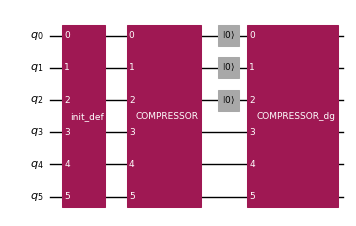

In [13]:
circuit = complete_circuit(typical_state, compressor, decompressor)
# Draw the circuit diagram.
circuit.draw('mpl', scale=0.5, style="iqp")

### Run the experiment without optimization

In [14]:
fidelities[0], figures[0] = experiment(
    test_input,
    compressor,
    decompressor,
    verbose=1
)

0 - 0.8021226380102118
1 - 0.8330036372949624
2 - 0.3731431420222526
3 - 0.7967746384457273
4 - 0.8866500881761725
5 - 0.7747655805604209
6 - 0.7630295315098891
7 - 0.5473896141756438
8 - 0.631609683371642
9 - 0.6967310222963279
10 - 0.5846398315068443
11 - 0.81043203924536
12 - 0.8031792145543494
13 - 0.7559136016657549
14 - 0.7201140056632568
15 - 0.8538033554890613
16 - 0.7399000919297796
17 - 0.7780964240335686
18 - 0.7746821530624028
19 - 0.7872308409492268


***
## Summary
***

In [15]:
zip_fidelities = list(zip(fidelities[0]))
# for i, (item1,) in enumerate(zip_fidelities):
#     print(i, '-', item1)

print('\navg', *np.average(zip_fidelities, axis=0))
print('min', *np.min(zip_fidelities, axis=0))
print('max', *np.max(zip_fidelities, axis=0))
print('std', *np.std(zip_fidelities, axis=0))


avg 0.7356605566981427
min 0.3731431420222526
max 0.8866500881761725
std 0.11736230109795384


0


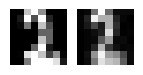

1


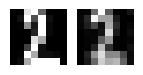

2


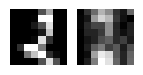

3


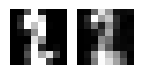

4


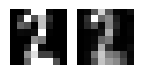

5


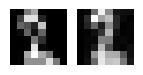

6


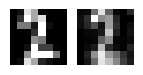

7


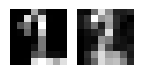

8


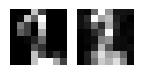

9


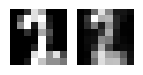

10


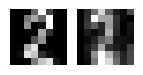

11


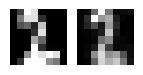

12


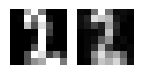

13


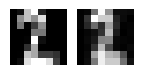

14


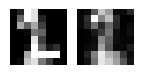

15


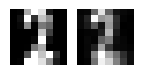

16


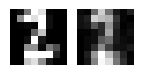

17


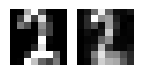

18


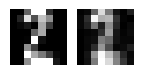

19


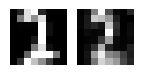

In [16]:
for i, (item1,) in enumerate(zip(figures[0])):
    print(i)
    plot_digits([item1[0], item1[1]], n_qubits)